In [2]:
import pandas as pd
from numpy import split
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
import os

Recurrent Neural Network

In [1]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

In [47]:
SEQUENCE_LEN = 10
EPOCHS = 10
INPUT_DIM = 6
HIDDEN_DIM = 200
LSTM_LAYERS = 1
LEARNING_RATE = 10e-4
BATCH_SIZE = 30

In [48]:
class DataPrep:
    def __init__(self):
        self.destdir = ""
        self.filenames = []
    
    def get_files(self):
        self.destdir = './data/training_data'
        self.filenames = [os.path.join(self.destdir,f) for f in os.listdir(self.destdir) if os.path.isfile(os.path.join(self.destdir,f))]
    
    def get_from_csv(self, filename):
        df = pd.read_csv(filename)
        df.columns = ["t", "v_leader", "x_leader",
                    "v_follower", "x_follower", "v_human", "x_human"]
        df.drop("t", axis=1, inplace=True)
        return df
    
    def get_data(self):
        print("Getting Data...")
        self.get_files()
        df = pd.DataFrame()
        print("Preparing Data...")
        i = 1
        for filename in self.filenames:
            temp_x = self.get_from_csv(filename)
            df = df.append(temp_x)
            if i % 20 == 19:
                print(f'Processed data for {i} file(s)')
            i += 1
        return df
    
    def normalize(self, df):
        # return (df - df.mean())/df.std()
        return df

In [49]:
def split_dataset(data):
    train, test_dataset = data[1:-299], data[-299:-(SEQUENCE_LEN - 1)]
    train = np.array(split(train, len(train)/SEQUENCE_LEN))
    test = np.array(split(test_dataset, len(test_dataset)/SEQUENCE_LEN))
    return train, test, test_dataset


def to_supervised(data, n_input, n_out=SEQUENCE_LEN):
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            x_input = data[in_start:in_end, :]
            X.append(x_input)
            # y.append(data[in_end:out_end, :])
            y.append(data[in_end, :])
        in_start += 1
    return np.array(X), np.array(y)


def build_model(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 1, EPOCHS, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


def forecast(model, data, n_input, steps=10):
    data = np.array(data)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    predictions = np.zeros((steps, input_x.shape[2]))
    for i in range(steps):
        yhat = model.predict(input_x, verbose=0)
        predictions[i] = yhat[0]
        temp = input_x[0][1:,:]  # Remove first row
        temp = np.concatenate((temp, yhat), 0) # Add predicted row
        input_x = temp.reshape((1, temp.shape[0], temp.shape[1]))
    return predictions


def evaluate_predictions(data, predictions):
    fig, axs = plt.subplots(3, 2)
    plot_axis = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]
    plots = ["v_leader", "x_leader",
                    "v_follower", "x_follower", "v_human", "x_human"]
    for i, (x,y) in enumerate(plot_axis):
        axs[x, y].plot(data[:, i], label="Data")
        axs[x, y].plot(predictions[:, i], label="Predicted")
        axs[x,y].set_title(plots[i])
    plt.legend()
    plt.show()

In [ ]:
data = DataPrep()
dataset = data.get_data()
train, test, test_dataset = split_dataset(dataset.values)
model = build_model(train, SEQUENCE_LEN)

[[  6.44188738 705.32733154   6.82338285 687.83062744   6.06347513
  662.27722168]
 [  6.44025469 705.82519531   6.83895111 688.38269043   6.0842514
  662.7532959 ]
 [  6.49259329 706.45874023   6.87092209 688.93231201   6.12229681
  663.16937256]
 [  6.5259347  707.11157227   6.85365725 689.54962158   6.12815619
  663.71112061]
 [  6.52382326 707.66192627   6.81233883 690.10247803   6.11748838
  664.2678833 ]
 [  6.55224037 708.2489624    6.81436729 690.64520264   6.13852739
  664.71203613]
 [  6.57651615 708.83917236   6.8063302  691.20465088   6.15218878
  665.19128418]
 [  6.58945799 709.41900635   6.79380417 691.78216553   6.15354252
  665.7734375 ]
 [  6.65280104 710.08721924   6.84752512 692.35974121   6.19938755
  666.18719482]
 [  6.68291903 710.74768066   6.82698441 692.99835205   6.22220373
  666.78637695]]


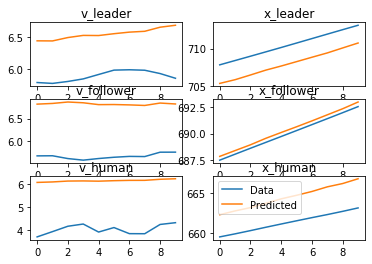

In [46]:
prediction_steps = 100
predictions = forecast(model, train, SEQUENCE_LEN, prediction_steps)
print(predictions)
evaluate_predictions(test_dataset[:prediction_steps], predictions)